In [1]:
import os
import json
import numpy as np
import pandas as pd
from pandas.io.json import json_normalize
from datetime import datetime 
from tqdm import tqdm
from sklearn.preprocessing import PowerTransformer
import umap
import matplotlib.pyplot as plt
import plotly.graph_objects as go
from scipy import stats

from sklearn.cluster import KMeans
from kmodes.kprototypes import KPrototypes


from lightgbm import LGBMClassifier
import shap
from sklearn.model_selection import cross_val_score

## Data Read

Data is taken from the Kaggle competition [here](https://www.kaggle.com/c/ga-customer-revenue-prediction). There's JSON format present in some of the column, so to read it in, you need a special function. I took the implementaion of load_df from this [Kaggle kernel](https://www.kaggle.com/julian3833/1-quick-start-read-csv-and-flatten-json-fields). It reads in a csv file and applies a specias parser to the specified JSON columns. Next it transforms the JSON elements into dataframe and merges them with the main dataframe.

In [2]:
def load_df(csv_path='train.csv', nrows=None):
    JSON_COLUMNS = ['device',  'geoNetwork','totals', 'trafficSource']
    
    df = pd.read_csv(csv_path, 
                     converters={column: json.loads for column in JSON_COLUMNS}, 
                     dtype={'fullVisitorId': 'str'}, # Important!!
                     nrows=nrows)
    
    for column in JSON_COLUMNS:
        column_as_df = json_normalize(df[column])
        column_as_df.columns = [f"{column}.{subcolumn}" for subcolumn in column_as_df.columns]
        df = df.drop(column, axis=1).merge(column_as_df, right_index=True, left_index=True)
    print(f"Loaded {os.path.basename(csv_path)}. Shape: {df.shape}")
    return df

In [3]:
train_df = load_df()

C:\Users\aruberts\AppData\Local\Continuum\anaconda3\envs\sp\lib\site-packages\ipykernel_launcher.py:10: FutureWarning: pandas.io.json.json_normalize is deprecated, use pandas.json_normalize instead
  # Remove the CWD from sys.path while we load stuff.


Loaded train.csv. Shape: (903653, 55)


This dataset is quite large, and since we only want to cluster our customers, most of it is useless. Let's find the visitor IDs that have purchased something in the past 12 months (that's the scope of our dataset) and filter the dataframe based on these IDs. 

In [5]:
#Filtering for users who have purchased
train_df['totals.transactionRevenue'] = train_df['totals.transactionRevenue'].fillna(0)

In [8]:
train_df['totals.transactionRevenue'] = train_df['totals.transactionRevenue'].astype(np.int64)
user_revenues = train_df.groupby('fullVisitorId')['totals.transactionRevenue'].sum()
users_with_purchase = user_revenues[user_revenues > 0].index.values
print(f'There are {len(users_with_purchase)} users who bought something')

There are ['0000213131142648941' '0002871498069867123' '0003450834640354121' ...
 '9997409246962677759' '9998597322098588317' '9998996003043230595'] users who bought something


In [11]:
#Filtering
customer_df = train_df.loc[train_df['fullVisitorId'].apply(lambda x: x in set(users_with_purchase)), :]

Saving data because it's much smaller now and easier to read in if we want to revisit the notebook

In [14]:
customer_df.to_csv('customer_ga_data.csv', index=False)

In [249]:
#Reading it in to make sure
customer_df = pd.read_csv('customer_ga_data.csv')

### Feature Engineering

Data here is on the session level, but we want to aggregate it to the user level. This aggregation should be meaningful, as we'll compare the customers according to these aggregated attributes. After some careful consideration, I've chosen the following metrics:
1. Most common channel grouping
2. Proportion of weekend visits
3. Median hour of visit
4. Total number of visits
5. Favourite browser
6. Favourite device type 
7. % of mobile visits
8. Favourite OS
9. Average hits per visit
10. Average pageviews per visit
11. % of bounce sessions
12. Preferred medium

Code below aggreates the dataset and gradually joins these features. Some of it is ugly, but hey it works :)

In [323]:
##Most common channel
full_data = pd.DataFrame(customer_df.groupby('fullVisitorId')['channelGrouping'].agg(lambda x: stats.mode(x)[0]))

#Weekend habits
customer_df['date'] = pd.to_datetime(customer_df['date'], format= '%Y%m%d')
customer_df['weekend'] = customer_df['date'].apply(lambda x: x.dayofweek in [5, 6]).astype(np.int8)
customer_df['weekday'] = customer_df['date'].apply(lambda x: x.dayofweek not in [5, 6]).astype(np.int8)

full_data = full_data.join(customer_df.groupby('fullVisitorId')[['weekend', 'weekday']].sum())
full_data['weekend_prop'] = full_data['weekend'] / (full_data['weekend'] + full_data['weekday'])
full_data.drop(['weekend', 'weekday'], axis=1, inplace=True)

#Time habits
customer_df['hour'] = customer_df['visitStartTime'].apply(lambda x: datetime.utcfromtimestamp(x).hour)
full_data = full_data.join(pd.DataFrame(customer_df.groupby('fullVisitorId')['hour'].median()))

#Number of visits
full_data = full_data.join(pd.DataFrame(customer_df.groupby('fullVisitorId')['sessionId'].nunique()))

#Favourite browser
full_data = full_data.join(pd.DataFrame(customer_df.groupby('fullVisitorId')['device.browser'].agg(lambda x: stats.mode(x)[0])))

#favourite device category
full_data = full_data.join(pd.DataFrame(customer_df.groupby('fullVisitorId')['device.deviceCategory'].agg(lambda x: stats.mode(x)[0])))

#Proportion of mobile
customer_df['device.isMobile'] = customer_df['device.isMobile'].astype(int)
full_data = full_data.join(pd.DataFrame(customer_df.groupby('fullVisitorId')['device.isMobile'].mean()))

#Favourite OS
full_data = full_data.join(pd.DataFrame(customer_df.groupby('fullVisitorId')['device.operatingSystem'].agg(lambda x: stats.mode(x)[0])))

#Average hits per visit
customer_df['totals.hits'] = customer_df['totals.hits'].astype(np.int)
full_data = full_data.join(pd.DataFrame(customer_df.groupby('fullVisitorId')['totals.hits'].median()))

#Average pageviews per visit
customer_df['totals.pageviews'] = customer_df['totals.pageviews'].fillna(0)
customer_df['totals.pageviews'] = customer_df['totals.pageviews'].astype(np.int)
full_data = full_data.join(pd.DataFrame(customer_df.groupby('fullVisitorId')['totals.pageviews'].median()))

#Proportion of bounce visits
customer_df['totals.bounces'] = customer_df['totals.bounces'].fillna(0).astype(np.int)
full_data = full_data.join(pd.DataFrame((customer_df.groupby('fullVisitorId')['totals.bounces'].sum() / customer_df.groupby('fullVisitorId')['totals.visits'].sum()), columns = ['bounce_prop']))

#Preferred medium
full_data = full_data.join(pd.DataFrame(customer_df.groupby('fullVisitorId')['trafficSource.medium'].agg(lambda x: stats.mode(x)[0])))

In [324]:
full_data.info()

<class 'pandas.core.frame.DataFrame'>
UInt64Index: 9996 entries, 213131142648941 to 9998996003043230595
Data columns (total 12 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   channelGrouping         9996 non-null   object 
 1   weekend_prop            9996 non-null   float64
 2   hour                    9996 non-null   float64
 3   sessionId               9996 non-null   int64  
 4   device.browser          9996 non-null   object 
 5   device.deviceCategory   9996 non-null   object 
 6   device.isMobile         9996 non-null   float64
 7   device.operatingSystem  9996 non-null   object 
 8   totals.hits             9996 non-null   float64
 9   totals.pageviews        9996 non-null   float64
 10  bounce_prop             9996 non-null   float64
 11  trafficSource.medium    9996 non-null   object 
dtypes: float64(6), int64(1), object(5)
memory usage: 1.3+ MB


In [325]:
full_data.head()

,channelGrouping,weekend_prop,hour,sessionId,device.browser,device.deviceCategory,device.isMobile,device.operatingSystem,totals.hits,totals.pageviews,bounce_prop,trafficSource.medium
fullVisitorId,,,,,,,,,,,,
213131142648941,Direct,0.000000,22.0,1,Chrome,desktop,0.0,Macintosh,14.0,13.0,0.0,(none)
435324061339869,Referral,0.666667,21.0,3,Chrome,desktop,0.0,Macintosh,14.0,11.0,0.0,referral
562678147042735,Organic Search,0.000000,14.0,2,Chrome,desktop,0.0,Macintosh,12.5,10.5,0.0,organic
585708896049892,Referral,0.000000,20.0,1,Chrome,desktop,0.0,Linux,22.0,20.0,0.0,referral
670722016498267,Referral,0.000000,17.0,2,Chrome,desktop,0.0,Linux,9.5,9.5,0.0,referral


With data in the right format, we can finally move to clustering. We'll try 2 approaches:
1. K-Means
2. K-Prototypes

K-Means is one of the most (if not the most) used clustering algorithms which is not surprising. It's fast, has a robust implementation in sklearn, and intuitively easy to understand. If you need a refresher on K-means, I highly recommend [this video](https://www.youtube.com/watch?v=4b5d3muPQmA). K-Prototypes is a lesser known sibling but offers an advantage of workign with mixed data types. It measures distance between numerical features using Euclidean distance (like K-means) but also measure the distance between categorical features using the number of matching categories. It was first published by [Huang (1998)](http://citeseerx.ist.psu.edu/viewdoc/download?doi=10.1.1.15.4028&rep=rep1&type=pdf) and was implemented in python using [this package](https://github.com/nicodv/kmodes). 

The code below clusters the data using these two methods and compares the outcomes.

### UMAP Embedding

One of the comparison methods will be visual, so we need a way to visualise the quality of clustering. I'll be using [Uniform Manifold Approximation and Projection for Dimension Reduction (UMAP)](https://umap-learn.readthedocs.io/en/latest/) - a dimensionality reduction technique (like PCA or t-SNE) - to embedd the data into 2 dimensions. This will allow me to visually see the groups of customers, and how well did the clustering algorithms do the job. There are 3 steps to get the proper embeddings:
1. Yeo-Johnson transform the numerical columns & One-Hot-Encode the categorical data
2. Embed these two column types separately
3. Combine the two by conditioning the numerical embeddings on the categorical embeddings as suggested [here](https://github.com/lmcinnes/umap/issues/58#issuecomment-419682509)

In [326]:
#Preprocessing numerical
numerical = full_data.select_dtypes(exclude='object')

for c in numerical.columns:
    pt = PowerTransformer()
    numerical.loc[:, c] = pt.fit_transform(np.array(numerical[c]).reshape(-1, 1))
    
##preprocessing categorical
categorical = full_data.select_dtypes(include='object')
categorical = pd.get_dummies(categorical)

#Percentage of columns which are categorical is used as weight parameter in embeddings later
categorical_weight = len(full_data.select_dtypes(include='object').columns) / full_data.shape[1]

#Embedding numerical & categorical
fit1 = umap.UMAP(metric='l2').fit(numerical)
fit2 = umap.UMAP(metric='dice').fit(categorical)


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/

In [333]:
categorical_weight

0.4166666666666667

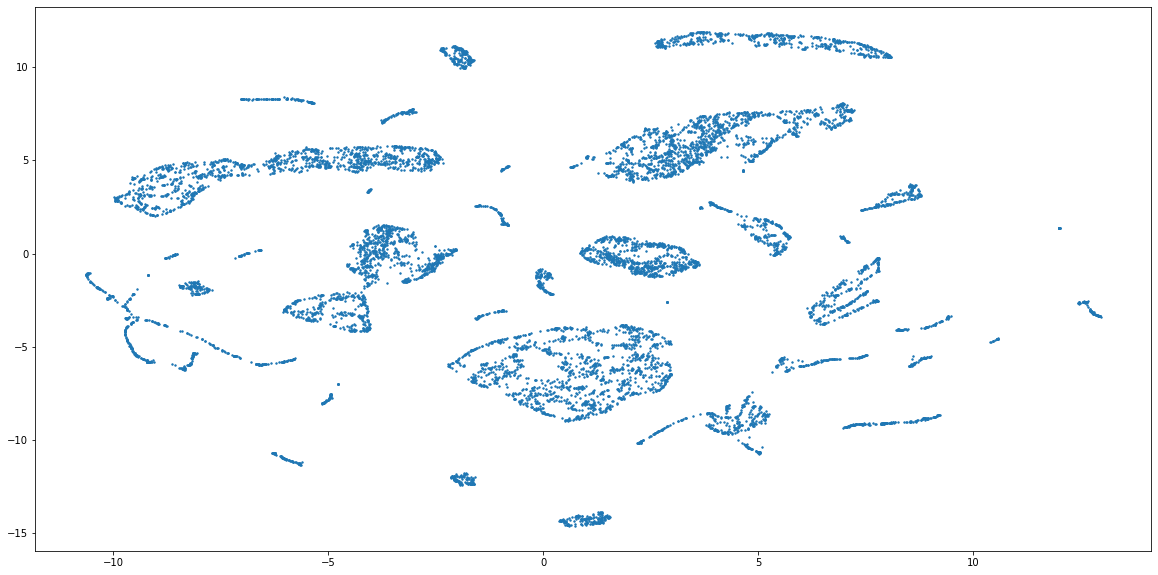

In [332]:
#Augmenting the numerical embedding with categorical
intersection = umap.umap_.general_simplicial_set_intersection(fit1.graph_, fit2.graph_, weight=categorical_weight)
intersection = umap.umap_.reset_local_connectivity(intersection)
embedding = umap.umap_.simplicial_set_embedding(fit1._raw_data, intersection, fit1.n_components, 
                                                fit1._initial_alpha, fit1._a, fit1._b, 
                                                fit1.repulsion_strength, fit1.negative_sample_rate, 
                                                200, 'random', np.random, fit1.metric, 
                                                fit1._metric_kwds, False)

plt.figure(figsize=(20, 10))
plt.scatter(*embedding.T, s=2, cmap='Spectral', alpha=1.0)
plt.show()

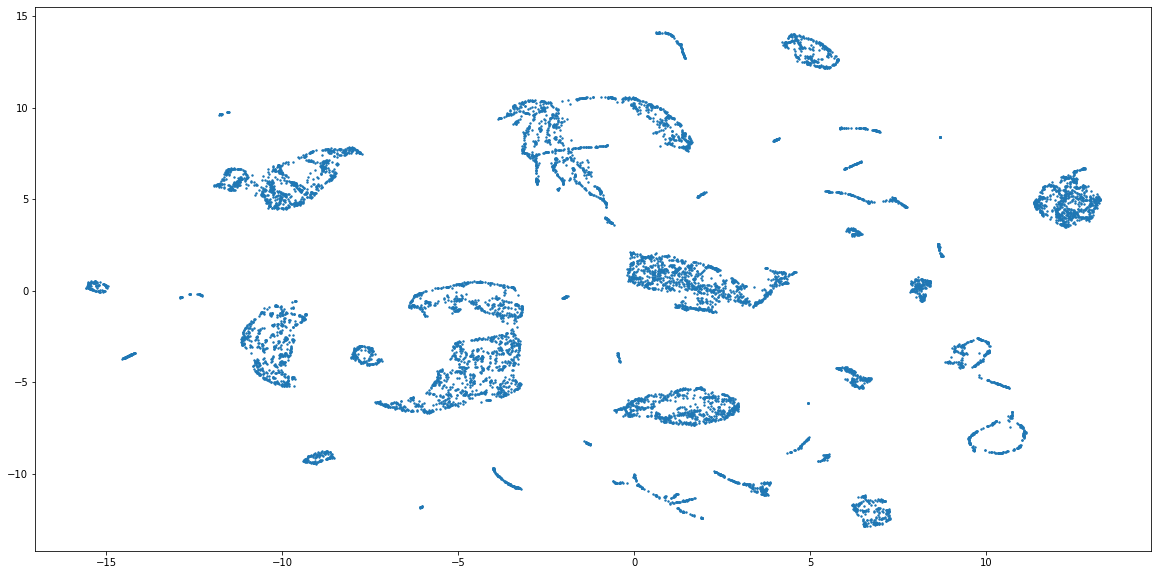

In [281]:
#Augmenting the numerical embedding with categorical
intersection = umap.umap_.general_simplicial_set_intersection(fit1.graph_, fit2.graph_, weight=categorical_weight)
intersection = umap.umap_.reset_local_connectivity(intersection)
embedding = umap.umap_.simplicial_set_embedding(fit1._raw_data, intersection, fit1.n_components, 
                                                fit1._initial_alpha, fit1._a, fit1._b, 
                                                fit1.repulsion_strength, fit1.negative_sample_rate, 
                                                200, 'random', np.random, fit1.metric, 
                                                fit1._metric_kwds, False)

plt.figure(figsize=(20, 10))
plt.scatter(*embedding.T, s=2, cmap='Spectral', alpha=1.0)
plt.show()

The combined embeddings seem to have about 15 distinct clusters, and a lot more smaller ones. For the sake of simplicity, I will cluster the data into 15 groups, but to find out the actual number of custer you can use something like elbow method (shown below as optional). Please note, that it is not given that this embedding has captured the distances properly, because the method of combining numerical and categorical is still very experimental in UMAP. But, because this form of evaluation is used only to compare the perfomance of two clustering methods, the representations can still be useful. 

Now, let's begin actual modelling with K-means amd K-Prototypes.

### KMeans with OHE

Because K-Means only works with numerical data, I'll:
1. One-Hot-Encode the categorical data
2. Apply the Yeo-Johnson transformation to the data to make it more Gaussian like
3. Fit K-Means with 15 clusters

In [334]:
data = pd.get_dummies(full_data)
for c in data.columns:
    pt = PowerTransformer()
    data.loc[:, c] = pt.fit_transform(np.array(data[c]).reshape(-1, 1))

In [335]:
kmeans = KMeans(n_clusters=15).fit(data)
kmeans_labels = kmeans.labels_

In [336]:
pd.Series(kmeans_labels).value_counts()

0     2131
8     1697
7     1570
2     1495
11     965
4      592
1      496
5      423
10     298
14     158
12     141
6       12
9       11
13       6
3        1
dtype: int64

#### (Optional) Elbow plot with intertia

In [247]:
#Elbow method to choose the optimal number of clusters
sse = {}
for k in tqdm(range(2, 50)):
    kmeans = KMeans(n_clusters=k, max_iter=1000).fit(data)
    sse[k] = kmeans.inertia_ # Inertia: Sum of distances of samples to their closest cluster center
    
fig = go.Figure(data=go.Scatter(x=list(sse.keys()), y=list(sse.values())))
fig.show()

100%|██████████████████████████████████████████████████████████████████████████████████| 48/48 [02:15<00:00,  2.83s/it]


### K-prototypes
For K-Prototypes, I'll apply the transformation to numerical data. Categorical data doesn't need any pre-processing.

In [337]:
kprot_data = full_data.copy()
for c in full_data.select_dtypes(exclude='object').columns:
    pt = PowerTransformer()
    kprot_data[c] =  pt.fit_transform(np.array(kprot_data[c]).reshape(-1, 1))
    

In [345]:
categorical_columns = [0, 4, 5, 7, 11] #make sure to specify correct indices

In [347]:
kproto = KPrototypes(n_clusters= 15, init='Cao', n_jobs = 4)
clusters = kproto.fit_predict(kprot_data, categorical=categorical_columns)

In [348]:
pd.Series(clusters).value_counts()

1     1243
4     1136
6      843
13     815
11     732
7      664
8      631
9      584
12     567
10     518
2      499
0      491
14     476
3      402
5      395
dtype: int64

#### (Optional) Elbow plot with cost

In [189]:
costs = []
n_clusters = []
clusters_assigned = []

for i in tqdm(range(2, 30)):
    try:
        kproto = KPrototypes(n_clusters= i, init='Cao', verbose=2)
        clusters = kproto.fit_predict(kprot_data, categorical=[0, 6, 7, 9, 13])
        costs.append(kproto.cost_)
        n_clusters.append(i)
        clusters_assigned.append(clusters)
    except:
        print(f"Can't cluster with {i} clusters")
        
fig = go.Figure(data=go.Scatter(x=n_clusters, y=costs ))
fig.show()

## Comparing two methods
Now we have two sets of cluster labels. First evaluation that I'm going to do is to color the dots of UMAP embeddings from above and see which make more sense. 

### Visual comparison

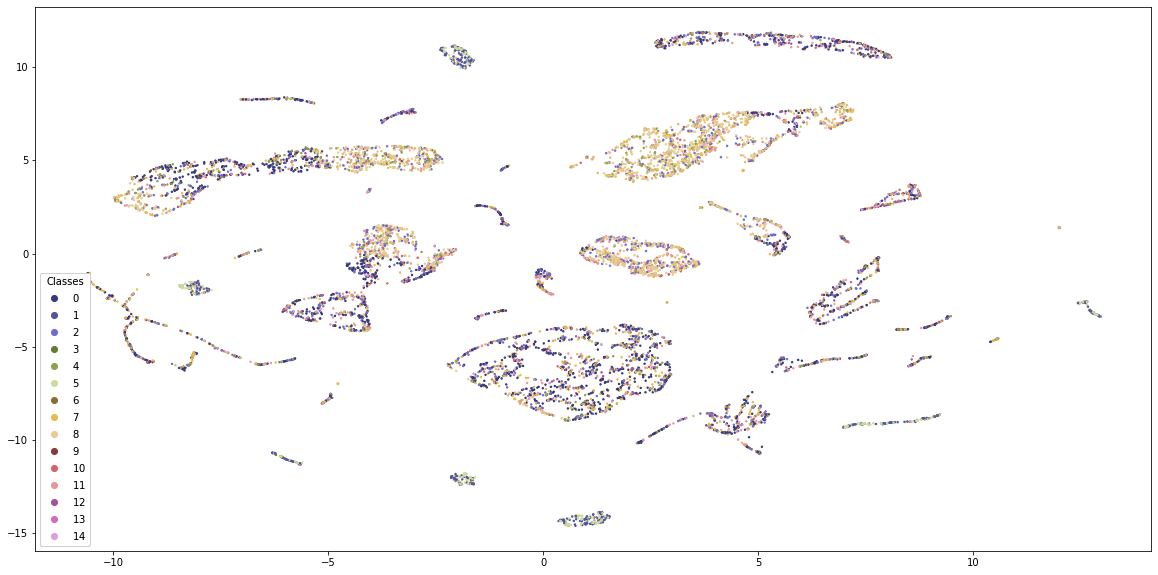

In [350]:
fig, ax = plt.subplots()
fig.set_size_inches((20, 10))
scatter = ax.scatter(embedding[:, 0], embedding[:, 1], s=2, c=kmeans_labels, cmap='tab20b', alpha=1.0)

# produce a legend with the unique colors from the scatter
legend1 = ax.legend(*scatter.legend_elements(num=15),
                    loc="lower left", title="Classes")
ax.add_artist(legend1)

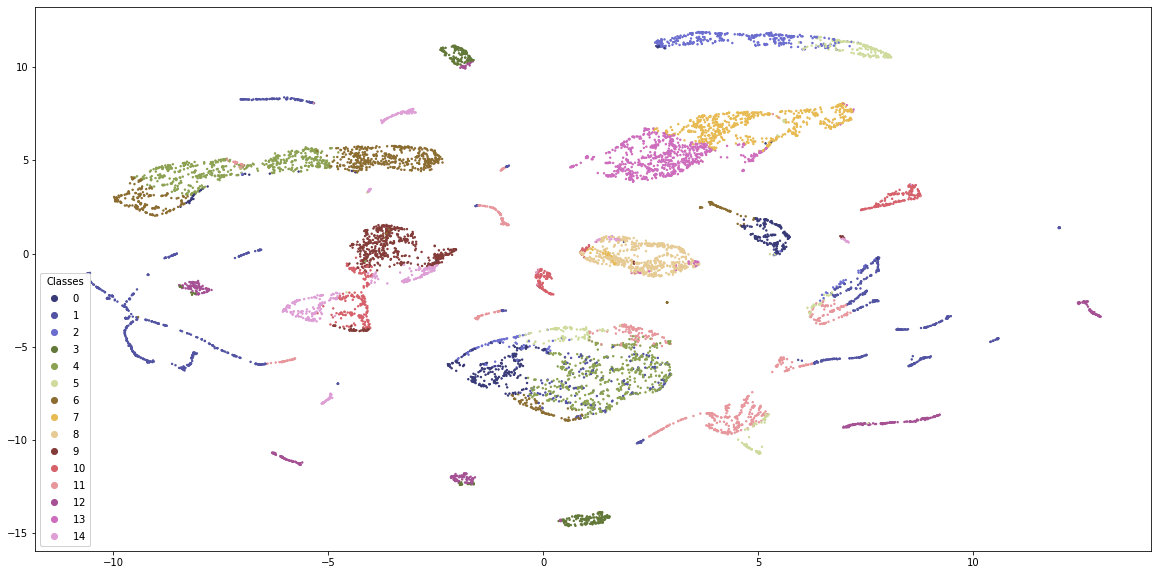

In [351]:
fig, ax = plt.subplots()
fig.set_size_inches((20, 10))
scatter = ax.scatter(embedding[:, 0], embedding[:, 1], s=2, c=clusters, cmap='tab20b', alpha=1.0)

# produce a legend with the unique colors from the scatter
legend1 = ax.legend(*scatter.legend_elements(num=15),
                    loc="lower left", title="Classes")
ax.add_artist(legend1)

Just by visual inspection,**K-Prototypes provides more distinguishable clusters**. K-Means is generally dominated by 4 clusters whereas K-Prototypes clusters are more equally distributed with clear boundaries. Still, some clusters appear in many places along the embedding scatterplot, so either the embeddings are flawed or the clustering misses something. 

### Classification evaluation
Another comparison that I'm going to do is by treating the clusters as labels and building a classification model on top. If the clusters are of high quality, the classification model will be able to predict them with high accuracy. At the same time, the models should use a variety of features to ensure that the clusters are not too simplistic. Overall, I'll check the quality by:
1. Distinctivness of clusters by cross-validated F1 score
2. The informativness of clusters by SHAP feature importances

#### K-Means

In [352]:
#Setting the objects to category 
lgbm_data = full_data.copy()
for c in lgbm_data.select_dtypes(include='object'):
    lgbm_data[c] = lgbm_data[c].astype('category')

In [353]:
#KMeans clusters
clf_km = LGBMClassifier(colsample_by_tree=0.8)
cv_scores_km = cross_val_score(clf_km, lgbm_data, kmeans_labels, scoring='f1_weighted')
print(f'CV F1 score for K-Means clusters is {np.mean(cv_scores_km)}')

The least populated class in y has only 1 members, which is less than n_splits=5.


CV F1 score for K-Means clusters is 0.985421371827738


In [354]:
clf_km.fit(lgbm_data, kmeans_labels)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_by_tree=0.8,
               colsample_bytree=1.0, importance_type='split', learning_rate=0.1,
               max_depth=-1, min_child_samples=20, min_child_weight=0.001,
               min_split_gain=0.0, n_estimators=100, n_jobs=-1, num_leaves=31,
               objective=None, random_state=None, reg_alpha=0.0, reg_lambda=0.0,
               silent=True, subsample=1.0, subsample_for_bin=200000,
               subsample_freq=0)

In [366]:
explainer_km = shap.TreeExplainer(clf_km)
shap_values_km = explainer_km.shap_values(lgbm_data)

Setting feature_perturbation = "tree_path_dependent" because no background data was given.


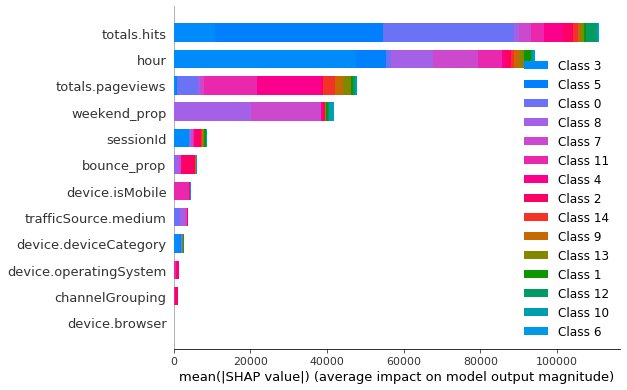

In [367]:
shap.summary_plot(shap_values_km, lgbm_data, plot_type="bar")

#### K-Prototypes

In [372]:
clf_kp = LGBMClassifier(colsample_by_tree=0.8)
cv_scores_kp = cross_val_score(clf_kp, lgbm_data, proto_clusters, scoring='f1_weighted')
print(f'CV F1 score for K-Prototypes clusters is {np.mean(cv_scores_kp)}')

CV F1 score for K-Prototypes clusters is 0.97086618690793


In [373]:
clf_kp.fit(lgbm_data, proto_clusters)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_by_tree=0.8,
               colsample_bytree=1.0, importance_type='split', learning_rate=0.1,
               max_depth=-1, min_child_samples=20, min_child_weight=0.001,
               min_split_gain=0.0, n_estimators=100, n_jobs=-1, num_leaves=31,
               objective=None, random_state=None, reg_alpha=0.0, reg_lambda=0.0,
               silent=True, subsample=1.0, subsample_for_bin=200000,
               subsample_freq=0)

In [370]:
explainer_kp = shap.TreeExplainer(clf_kp)
shap_values_kp = explainer_kp.shap_values(lgbm_data)

Setting feature_perturbation = "tree_path_dependent" because no background data was given.


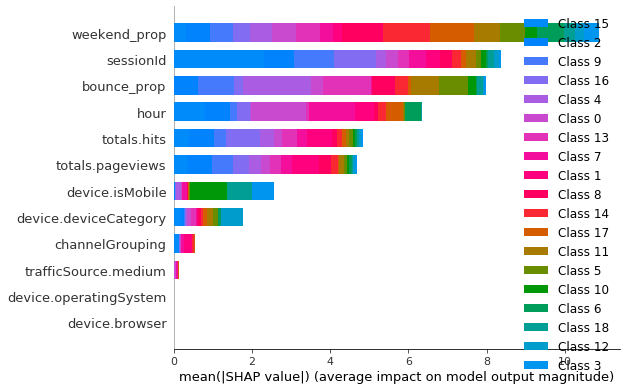

In [371]:
shap.summary_plot(shap_values_kp, lgbm_data, plot_type="bar")

Classifiers for both of the clustering methods have F1 score close to 1 which means that **K-Means and K-prototypes have produced clusters that are easily distinguishable**. Yet, to classify the K-Prototypes correctly, LightGBM uses more features (8-9), and some of the categorical features become important. This is in contrast to K-Means which could have been almost perfectly classified using just 4-5 features. This proves that the **clusters produced by K-Prototypes are more informative**. 